# Case Study 3 : Patient Drug Review

Tha Songtan Suppasadid<br>
Nichakan Udomlerkchai<br>
Peeranon Posawang<br>
<br>
Last edited: 2/28/2020 9:17 PM<br>
Helsinki Metropolia University of Applied Science


## Background

## Data

In [1]:
import time # for timing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split # preprocessing datasets
from tensorflow.keras.preprocessing.text import Tokenizer # text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences # text preprocessing
from tensorflow.keras.models import Sequential # modeling neural networks
from tensorflow.keras.layers import Dense, Activation # layers for neural networks
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score # final metrics
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers,models,optimizers,metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding,LSTM,TimeDistributed,Activation
from tensorflow.keras.models import Model

In [2]:
train = pd.read_csv('data/drugsComTrain_raw.csv')

In [3]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
test = pd.read_csv('data/drugsComTest_raw.csv')

In [5]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [6]:
train.shape

(161297, 7)

In [7]:
test.shape

(53766, 7)

In [8]:
%%time
# Tokenize the text
samples = train['review']
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 51429 unique tokens.
CPU times: user 18.3 s, sys: 187 ms, total: 18.5 s
Wall time: 18.7 s


In [9]:
data = pad_sequences(sequences, maxlen=200)

In [10]:
%%time
# Create three categories
# label = 4, when rating == 10
# label = 3, when rating == 8...9
# label = 2, when rating = 5..7
# label = 1, when rating = 2..4
# label = 0, when rating = 1
labels = train['rating'].values
for i in range(len(labels)):
    x = labels[i]
    if x == 10:
        labels[i] = 4
    elif x >= 8:
        labels[i] = 3
    elif x >= 5:
        labels[i] = 2
    elif x >= 2:
        labels[i] = 1
    else:
        labels[i] = 0

CPU times: user 123 ms, sys: 2.41 ms, total: 126 ms
Wall time: 125 ms


In [11]:
from tensorflow.keras.utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (161297, 200)
Shape of label tensor: (161297, 5)


In [12]:
VALIDATION_SPLIT = 0.25

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

# Model 1

In [13]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

In [14]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            82048 

In [15]:
%%time
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

Train on 120973 samples, validate on 40324 samples
Epoch 1/10
120973/120973 [==============================] - 124s 1ms/sample - loss: 1.2360 - acc: 0.4491 - val_loss: 1.1782 - val_acc: 0.4888
Epoch 2/10
120973/120973 [==============================] - 122s 1ms/sample - loss: 1.0575 - acc: 0.5396 - val_loss: 1.0973 - val_acc: 0.5143
Epoch 3/10
120973/120973 [==============================] - 123s 1ms/sample - loss: 0.9580 - acc: 0.5874 - val_loss: 1.2391 - val_acc: 0.4974
Epoch 4/10
120973/120973 [==============================] - 123s 1ms/sample - loss: 0.8480 - acc: 0.6425 - val_loss: 1.1694 - val_acc: 0.5295
Epoch 5/10
120973/120973 [==============================] - 123s 1ms/sample - loss: 0.7284 - acc: 0.7007 - val_loss: 1.0183 - val_acc: 0.6032
Epoch 6/10
120973/120973 [==============================] - 121s 1ms/sample - loss: 0.6116 - acc: 0.7542 - val_loss: 1.0675 - val_acc: 0.6173
Epoch 7/10
120973/120973 [==============================] - 121s 1ms/sample - loss: 0.5137 - acc:

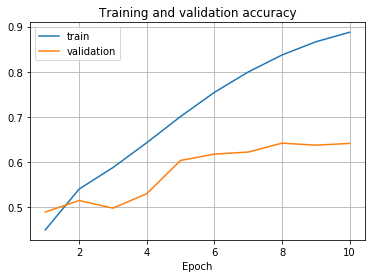

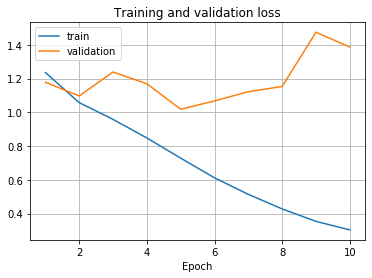

In [16]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = np.arange(len(acc)) + 1

plt.plot(e, acc, label = 'train')
plt.plot(e, val_acc, label = 'validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.figure()

plt.plot(e, loss, label = 'train')
plt.plot(e, val_loss, label = 'validation')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

In [17]:
# Find the predicted values for the validation set
y_pred = np.argmax(model.predict(x_val), axis = 1)
y_true = np.argmax(y_val, axis = 1)

In [18]:
# Calculate the classification report
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.65      0.73      0.69      5281
           1       0.47      0.68      0.56      4658
           2       0.55      0.49      0.52      5937
           3       0.63      0.67      0.65     11701
           4       0.80      0.63      0.71     12747

    accuracy                           0.64     40324
   macro avg       0.62      0.64      0.63     40324
weighted avg       0.66      0.64      0.64     40324



In [19]:
cm = confusion_matrix(y_true, y_pred).T
print(cm)

[[3853  774  367  336  573]
 [1026 3165 1517  618  340]
 [ 166  399 2908 1309  497]
 [ 143  242  901 7842 3258]
 [  93   78  244 1596 8079]]


In [20]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.536
Cohen's kappa (quadratic) = 0.756


# Model 2

In [21]:
len(x_train)

120973

In [32]:
vocabulary = 5000
hidden_size = 128
num_steps = 200

# model = models.Sequential()
# model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
# model.add(LSTM(hidden_size,activation='tanh', return_sequences=True))
# model.add(LSTM(hidden_size,activation='tanh', return_sequences=True))
# #model.add(LSTM(hidden_size, return_sequences=True))
# #model.add(TimeDistributed(Dense(vocabulary)))
# model.add(GlobalMaxPooling1D())
# model.add(layers.Dense(64,activation='tanh'))
# model.add(layers.Dense(5,activation='softmax'))
# model.summary()

model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(layers.SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          640000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 128)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200, 128)          131584    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 903,813
Trainable params: 903,813
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
%%time
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

Train on 120973 samples, validate on 40324 samples
Epoch 1/10
120973/120973 [==============================] - 1279s 11ms/sample - loss: 1.2548 - acc: 0.4461 - val_loss: 1.1535 - val_acc: 0.4972
Epoch 2/10
120973/120973 [==============================] - 1250s 10ms/sample - loss: 1.1482 - acc: 0.5028 - val_loss: 1.1033 - val_acc: 0.5205
Epoch 3/10
120973/120973 [==============================] - 1247s 10ms/sample - loss: 1.0680 - acc: 0.5368 - val_loss: 1.0692 - val_acc: 0.5312
Epoch 4/10
120973/120973 [==============================] - 1245s 10ms/sample - loss: 1.0327 - acc: 0.5525 - val_loss: 1.0566 - val_acc: 0.5361
Epoch 5/10
120973/120973 [==============================] - 1284s 11ms/sample - loss: 1.0053 - acc: 0.5644 - val_loss: 1.0382 - val_acc: 0.5417
Epoch 6/10
120973/120973 [==============================] - 1241s 10ms/sample - loss: 0.9777 - acc: 0.5773 - val_loss: 1.0310 - val_acc: 0.5507
Epoch 7/10
120973/120973 [==============================] - 1243s 10ms/sample - loss:

In [36]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

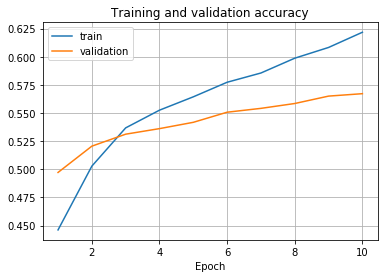

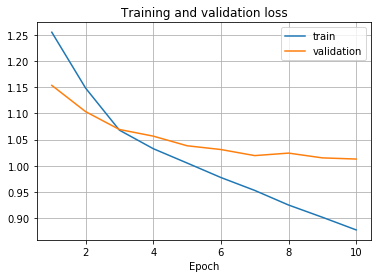

In [37]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = np.arange(len(acc)) + 1

plt.plot(e, acc, label = 'train')
plt.plot(e, val_acc, label = 'validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.figure()

plt.plot(e, loss, label = 'train')
plt.plot(e, val_loss, label = 'validation')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

In [38]:
# Find the predicted values for the validation set
y_pred = np.argmax(model.predict(x_val), axis = 1)
y_true = np.argmax(y_val, axis = 1)

In [39]:
y_pred

array([3, 4, 3, ..., 3, 4, 4])

In [40]:
# Calculate the classification report
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.62      0.71      0.66      5281
           1       0.43      0.44      0.43      4658
           2       0.47      0.33      0.39      5937
           3       0.52      0.57      0.55     11701
           4       0.67      0.66      0.66     12747

    accuracy                           0.57     40324
   macro avg       0.54      0.54      0.54     40324
weighted avg       0.56      0.57      0.56     40324



In [41]:
cm = confusion_matrix(y_true, y_pred).T
print(cm)

[[3740 1352  412  236  273]
 [1021 2055 1208  345  176]
 [ 198  764 1980  978  252]
 [ 168  355 1920 6680 3631]
 [ 154  132  417 3462 8415]]


In [42]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.431
Cohen's kappa (quadratic) = 0.775
